# import modules

In [1]:
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input,regularizers
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply,BatchNormalization,MaxPool1D
from keras.models import Model


from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np
from keras.wrappers import scikit_learn

# Load Features

In [7]:
y=np.load('./feature/y_initial.npy')
X_features=np.load('./feature/X_gabor.npy')

In [8]:
X_features.shape

(4704, 35, 7)

In [9]:
y.shape

(4704, 2)

In [10]:
y[0]

array(['1', '0'], dtype='<U2')

In [11]:
alphabet_set={'0': 0,'b': 1, 'c': 2,'d': 3,'f': 4,'g': 5,'h': 6,'j': 7,'k': 8,'l': 9, 'm': 10,'n': 11,'p': 12,'q': 13,
          'r': 14,'s': 15,'t': 16,'w': 17,'x': 18,'y': 19,'z': 20}

In [12]:
alphabet_set={value:key for key,value in alphabet_set.items()}

## One-hot Encoding

In [13]:
y=to_categorical(y,num_classes=21)

In [14]:
y.shape

(4704, 2, 21)

## split train and test

In [15]:
X_train, X_test, y_train, y_test=train_test_split(X_features,y,test_size=0.1,random_state=2019)

In [16]:
X_train.shape,X_test.shape

((4233, 35, 7), (471, 35, 7))

In [17]:
y_train.shape,y_test.shape

((4233, 2, 21), (471, 2, 21))

# Models


In [2]:
NUM_CLASSES=21
BATCH_SIZE=32
EPOCHS=100
MODEL_SAVE_PATH='.\model\initial_gabor_cnn.h5'

In [3]:
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax', name='attention')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model():
    inputs = Input(shape=(35, 7))
    x=BatchNormalization()(inputs)
    x = Conv1D(filters = 32, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(x)  #, padding = 'same'
    x = MaxPool1D()(x)
    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul=MaxPool1D(pool_size=10,strides=4)(attention_mul)
    output = Dense(21, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model


In [4]:
model = attention_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35, 7)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 35, 7)        28          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 35, 32)       256         batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 17, 32)       0           conv1d[0][0]                     
_______________________________________________________________________________________

In [1]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

NameError: name 'model' is not defined

In [79]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
plot_model(model,'model_initial.jpg',show_shapes=True)
lr_reduce=kcallbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=6,verbose=1,min_lr=0.00001)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model,lr_reduce]
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,y_test),
                  callbacks=callback_list)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/100
131/133 [============================>.] - ETA: 0s - loss: 2.4869 - accuracy: 0.4351
Epoch 00001: val_accuracy improved from -inf to 0.43312, saving model to .\model\initial_gabor_cnn.h5
133/133 [==============================] - 3s 20ms/step - loss: 2.4851 - accuracy: 0.4352 - val_loss: 2.2789 - val_accuracy: 0.4331
Epoch 2/100
130/133 [============================>.] - ETA: 0s - loss: 2.1419 - accuracy: 0.4385
Epoch 00002: val_accuracy did not improve from 0.43312
133/133 [==============================] - 1s 11ms/step - loss: 2.1390 - accuracy: 0.4387 - val_loss: 2.0026 - val_accuracy: 0.4331
Epoch 3/100
130/133 [============================>.] - ETA: 0s - loss: 1.8970 - accuracy: 0.4388
Epoch 00003: val_accuracy did not improve from 0.43312
133/133 [==============================] - 2s 11ms/step - loss: 1.8963 - accuracy: 0.

## plot_curve

In [ ]:
from sklearn.metrics import classification_report
model.load_weights('./models/pinyin_cnn.h5')

In [32]:
from help import plot_curve,plot_curve_with_smooth

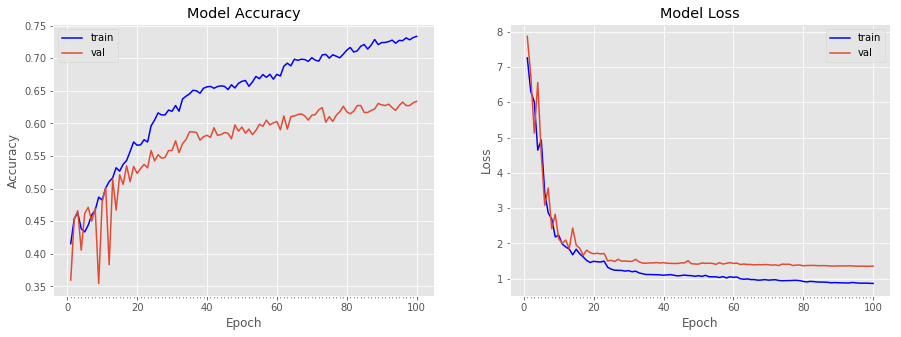

In [33]:
plot_curve(history)

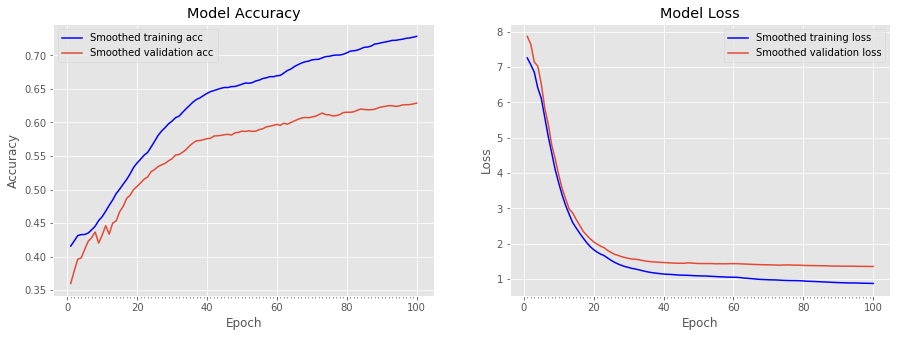

In [34]:
plot_curve_with_smooth(history)

## confusion_metrix

In [30]:
model.load_weights('./model/initial_gabor_cnn.h5')

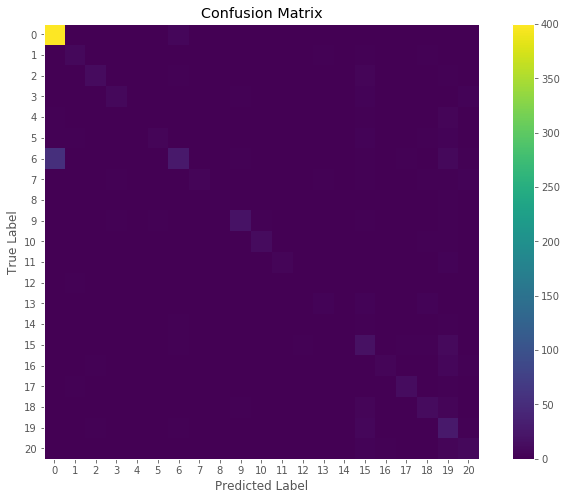

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_test,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
def plot_confusion_matrix(confusion_mat):
    plt.figure(figsize=(12,8))
    plt.imshow(confusion_mat)
    plt.title('Confusion Matrix')
    plt.colorbar()
    labels = list(range(0,21))
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.show() 
plot_confusion_matrix(con_matrix)

## classfication_report

In [37]:
from sklearn.metrics import classification_report


In [38]:
target_names=[alphabet_set[i] for i in range(21)]
print(classification_report(y_true,y_pred,digits=4,labels=list(range(21)),target_names=target_names))

             precision    recall  f1-score   support

          0     0.8677    0.9804    0.9206       408
          b     0.4706    0.4000    0.4324        20
          c     0.5714    0.4615    0.5106        26
          d     0.5000    0.4000    0.4444        20
          f     0.0000    0.0000    0.0000        14
          g     0.3529    0.2222    0.2727        27
          h     0.5294    0.2621    0.3506       103
          j     0.8571    0.2400    0.3750        25
          k     0.6000    0.3750    0.4615         8
          l     0.6452    0.5882    0.6154        34
          m     0.6471    0.5789    0.6111        19
          n     0.5455    0.4286    0.4800        14
          p     0.2500    0.1429    0.1818         7
          q     0.2667    0.2353    0.2500        17
          r     0.2500    0.0909    0.1333        11
          s     0.2571    0.3913    0.3103        46
          t     0.5000    0.2857    0.3636        21
          w     0.5417    0.5909    0.5652   

# predict test

In [39]:

temp = np.load('./gabor/person1_time1_group1_da_4.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:d


In [40]:

temp = np.load('./gabor/person1_time1_group1_ba_1.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:m


In [42]:

temp = np.load('./gabor/person1_time1_group1_he_2.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)

pred=np.argmax(pred,axis=-1)[0]
text=[alphabet_set[i] for i in pred]
text=[i for i in text if i!='0']
text=''.join(text)
print('Predict Label:%s'%(text))

(1, 35, 7)
Predict Label:h
